# Logistic Regression Classifier

The goal of this notebook is to classify our samples using a Logistic Regression model. We will attempt 3 different variations in terms of target variables.

1. Each individual accent
2. Consolidated accents (North, Mid, South, West)
3. Further consolidated regions (East, west)




In [3]:
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, pairwise_distances, confusion_matrix

from matplotlib.colors import ListedColormap


from sklearn.linear_model import LogisticRegression


In [2]:
def plot_conf_matconf(conf_mat, save_fig=None):
    fig = plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells

    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)

    if save_fig:
        plt.savefig(f'{save_fig}.png')

    plt.show()

In [4]:
def average_speakers(mfcc_df):
    feature_cols = [x for x in mfcc_df.columns if 'feature' in x]
    
    target = mfcc_df[['speaker', 'accent']].drop_duplicates()
    
    mfcc_grouped = mfcc_df.groupby(['speaker', 'word'])[feature_cols].mean().reset_index()
    
    joined = pd.merge(how='left', left=mfcc_grouped, right = target, left_on='speaker', right_on = 'speaker')
    
    return joined



def load_data():
    train = pd.read_csv('all_words_train_mfcc.csv')
    test = pd.read_csv('all_words_test_mfcc.csv')
    
    train = train.loc[train['accent'] != 'DR8']
    test = test.loc[test['accent'] != 'DR8']
    
    train = average_speakers(train)
    
    return train, test


train, test = load_data()

In [11]:
test.accent.value_counts()

DR4    2714
DR5    2438
DR2    2281
DR3    2271
DR7    1967
DR6     965
DR1     960
Name: accent, dtype: int64

C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


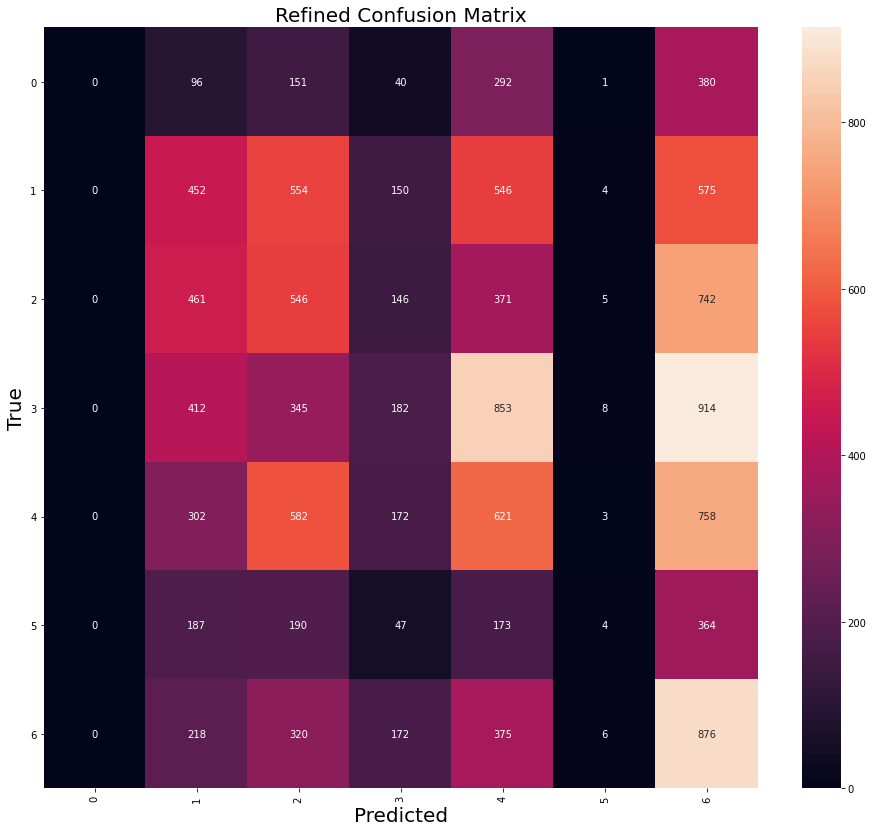

Logistic Reg Number of mislabeled points out of a total 13596 points : 10915
             DR1          DR2          DR3          DR4          DR5  \
precision    0.0     0.212406     0.203125     0.200220     0.192201   
recall       0.0     0.198159     0.240423     0.067060     0.254717   
f1-score     0.0     0.205035     0.220206     0.100469     0.219086   
support    960.0  2281.000000  2271.000000  2714.000000  2438.000000   

                  DR6          DR7  accuracy     macro avg  weighted avg  
precision    0.129032     0.190063   0.19719      0.161007      0.180652  
recall       0.004145     0.445348   0.19719      0.172836      0.197190  
f1-score     0.008032     0.266423   0.19719      0.145607      0.169637  
support    965.000000  1967.000000   0.19719  13596.000000  13596.000000  


In [9]:
def logistic_reg(train, test, display_conf=True, word=None, features = None):
    if features:
        feature_cols = features
        
    else:
        feature_cols = [x for x in train.columns if 'feature' in x]

    if word:
        train = train.loc[train['word'] == word]
        test = test.loc[test['word'] == word]
        
        
    X_train = train[feature_cols]
    y_train = train['accent']
    
    X_test = test[feature_cols]
    y_test = test['accent']
        
    logit = LogisticRegression(max_iter = 1250)
    logit.fit(X_train, y_train)
    
    y_pred = logit.predict(X_test)
    
    conf_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

    if display_conf:
        conf_mat = confusion_matrix(y_test, y_pred)
        plot_conf_matconf(conf_mat)
    
        print("Logistic Reg Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))    
        print(conf_df)
    
    
    return logit, y_pred, conf_df


logit, logit_y_pred, logit_conf = logistic_reg(train, test)



In [12]:
consolidate_region_map = {
    'DR1': 'North',
    'DR2': 'North',
    'DR3': 'Mid',
    'DR4': 'Mid',
    'DR5': 'South',
    'DR6': 'North',
    'DR7': 'West',
}



def consolidate_regions(train, test, dict_map):
    condensed_train = train.copy()
    condensed_train['region'] = condensed_train['accent'].map(dict_map)
    condensed_train['accent'] = condensed_train['region']
    
    condensed_test = test.copy()
    condensed_test['region'] = condensed_test['accent'].map(dict_map)
    condensed_test['accent'] = condensed_test['region']
    
    return condensed_train, condensed_test


In [15]:
condensed_train, condensed_test = consolidate_regions(train, test, consolidate_region_map)

condensed_test.accent.value_counts()

Mid      4985
North    4206
South    2438
West     1967
Name: accent, dtype: int64

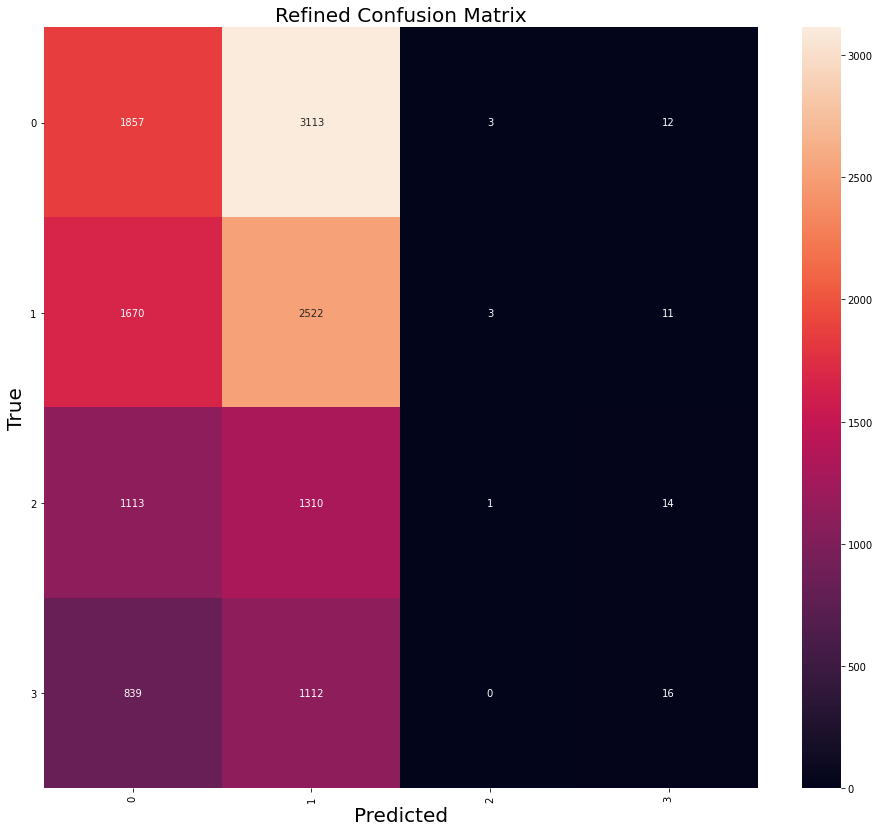

Logistic Reg Number of mislabeled points out of a total 13596 points : 9200
                   Mid        North        South         West  accuracy  \
precision     0.338930     0.313020     0.142857     0.301887   0.32333   
recall        0.372518     0.599620     0.000410     0.008134   0.32333   
f1-score      0.354931     0.411319     0.000818     0.015842   0.32333   
support    4985.000000  4206.000000  2438.000000  1967.000000   0.32333   

              macro avg  weighted avg  
precision      0.274174      0.290396  
recall         0.245170      0.323330  
f1-score       0.195727      0.259819  
support    13596.000000  13596.000000  


In [14]:
logit, logit_y_pred, logit_conf = logistic_reg(condensed_train, condensed_test)
